In [1]:
import huggingface_hub
if not hasattr(huggingface_hub, "cached_download"):
    from huggingface_hub import hf_hub_download
    huggingface_hub.cached_download = hf_hub_download
import os
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_msssim import ms_ssim
import torchvision.transforms.functional as TF
from safetensors.torch import load_file
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
# your classes
from controlnet.flownet import DualFlowControlNet
from pipeline import StableDiffusionDualFlowControlNetPipeline
from controlnet.utils import load_controls_and_flows

# ---------------------------
# Load models (aligned SD-1.5)
# ---------------------------
dtype = torch.float32
base = "stable-diffusion-v1-5/stable-diffusion-v1-5"

vae = AutoencoderKL.from_pretrained(base, subfolder="vae", torch_dtype=dtype)
unet = UNet2DConditionModel.from_pretrained(base, subfolder="unet", torch_dtype=dtype)
text_encoder = CLIPTextModel.from_pretrained(base, subfolder="text_encoder", torch_dtype=dtype)
tokenizer = CLIPTokenizer.from_pretrained(base, subfolder="tokenizer")
scheduler = UniPCMultistepScheduler.from_pretrained(base, subfolder="scheduler")

# --- ControlNet: load your subclass weights ---
controlnet = DualFlowControlNet(
    block_out_channels=tuple(unet.config.block_out_channels),     # (320, 640, 1280, 1280)
    layers_per_block=2,
    cross_attention_dim=768,   
 )
# controlnet.load_state_dict(torch.load("path/to/controlnet.safetensors" or ".pth", map_location="cpu"))

# sanity: cross-attn dims must match (768 for SD1.x)
assert unet.config.cross_attention_dim == text_encoder.config.hidden_size == 768
if hasattr(controlnet, "config") and hasattr(controlnet.config, "cross_attention_dim"):
    assert controlnet.config.cross_attention_dim == 768, f"ControlNet CAD={controlnet.config.cross_attention_dim}"

ckpt = load_file('experiments/controlnet/checkpoint-97000/controlnet/diffusion_pytorch_model.safetensors')
controlnet.load_state_dict(ckpt,strict=False)

safety_checker = None
feature_extractor = None

# ---------------------------
# Build pipeline
# ---------------------------
pipe = StableDiffusionDualFlowControlNetPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    controlnet=controlnet,
    scheduler=scheduler,
    safety_checker=safety_checker,
    feature_extractor=feature_extractor,
)
pipe = pipe.to("cuda")

# Validation data:
device = pipe.device

local_conditions = []
flow_conditions = []
prompts = ["A beautiful blonde girl smiling with pink lipstick with black background",
           "A Yacht with a red flag ,sailing in front of the Bosphorus in Istanbul , and bridge with cars is in the background." , 
           "A German shepherd shakes off water in the middle of a forest trail",
           "Honeybees hover among blooming purple flowers"]

/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::fla

In [4]:
videos = ['Beauty', 'Bosphorus', 'ShakeNDry', 'HoneyBee']
for video in videos:
    local,flow = load_controls_and_flows(
    f'data/{video}/images/frame_0000.png',
    f'data/{video}/images/frame_0004.png',
    f'data/{video}/optical_flow/optical_flow_gop_4_raft/flow_0000_0003.flo',
    f'data/{video}/optical_flow_bwd/optical_flow_gop_4_raft/flow_0004_0003.flo',
    size=(1024, 1024),
    device=device,
    dtype=dtype,
)
    local_conditions.append(local) 
    flow_conditions.append(flow)

In [11]:
flow[0][:2].shape

torch.Size([2, 1024, 1024])

In [21]:
from patch_utils import *

im1,im2 = local[0][:3], local[0][3:]
print(im1.shape, im2.shape)

tile_size = (512,512) 
im1_tiles,coords,_  = crop_into_tiles(im1, tile_size, overlap=64, order="chw")
im2_tiles,coords,_ = crop_into_tiles(im2, tile_size, overlap=64, order="chw")

fwd,bwd = flow[0][:2], flow[0][2:]
fwd_tiles,coords,_ = crop_into_tiles(fwd, tile_size, overlap=64, order="chw")
bwd_tiles ,coords,_ = crop_into_tiles(bwd, tile_size, overlap=64, order="chw")

torch.Size([3, 1024, 1024]) torch.Size([3, 1024, 1024])


In [22]:
print('no of tiles', len(im1_tiles))

no of tiles 9


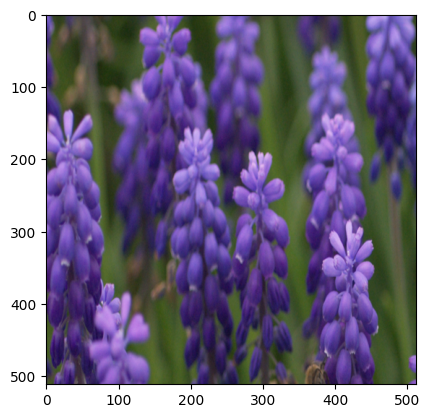

In [23]:
plt.imshow(im2_tiles[0].permute(1,2,0).detach().cpu().numpy())

In [32]:
x=  torch.cat((im1_tiles[0], im2_tiles[0]), dim=0).unsqueeze(0)
print(x.shape)


y = torch.cat((fwd_tiles[0], bwd_tiles[0]), dim=0).unsqueeze(0)
y.shape

torch.Size([1, 6, 512, 512])


torch.Size([1, 4, 512, 512])

In [33]:
pipe.enable_freeu(s1=0.9, s2=0.2, b1=1.2, b2=1.4)
img_size = 512
out = pipe(
        prompt=prompts[3],
        controlnet_cond=x,
        flow_cond=y,
        height=img_size,
        width=img_size,
        num_inference_steps=40,
        guidance_scale=6, # Use the current guidance scale
        negative_prompt=None,
        num_images_per_prompt=1, # Generate one image per setting for efficiency
        controlnet_conditioning_scale=1.5, # Use the current controlnet scale
        guess_mode=False,
        output_type="pil",
        return_dict=True,
    )

  0%|                                                                                  | 0/40 [00:00<?, ?it/s]/data/maryamsana_98/DiffCodec-Controlling-Latent-Diffusion-for-Perceptual-Video-Compression/controlnet/control_utils.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/data/maryamsana_98/DiffCodec-Controlling-Latent-Diffusion-for-Perceptual-Video-Compression/controlnet/control_utils.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.62it/s]


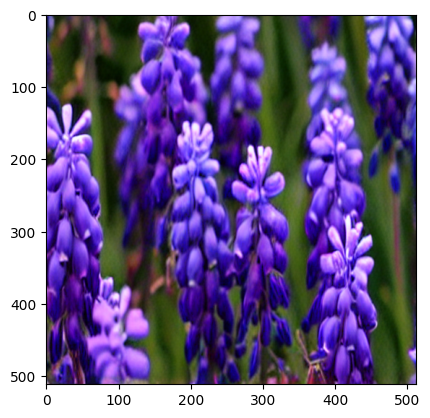

In [36]:
plt.imshow(out.images[0])